In [3]:
import json
import glob
import matplotlib.pylab as plt
import numpy as np
from scipy.special import erf
import sys
sys.path.append('./../../Figures/')
import makeCorner

Load `.json` result files which contains
1. direct output from `emcee` interference, without any processing
2. post-processed output from `emcee` inference

and make dict containing info for all populations under the given model

In [4]:
# For loading files
model = 'betaPlusGaussian'
pops = ['1', '2', '3']
nevents = ['70', '250'] 
date = '053023'

# Make Dict
data_dict = {}

# Cycle through the different populations and no. of events
for pop in pops: 
    data_pop = {}
    for nevent in nevents: 
        
        name = f"{model}_pop{pop}_{nevent}events_highmass_{date}"
        
        with open(f'{model}/{name}.json', 'r') as f:
            data = json.load(f)
            
        data_pop[nevent+' events'] = data    
            
    data_dict['pop '+pop] = data_pop

FileNotFoundError: [Errno 2] No such file or directory: 'betaPlusGaussian/betaPlusGaussian_pop1_250events_highmass_052223.json'

In [2]:
# Names of populations from paper for plotting below
population_labels_dict = {
    'pop 1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop 2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop 3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

# Colors corresponding to different numbers of events
nevents_colors_dict = {
    '70 events':'#d0856a', 
    '250 events':'#B13306'
}

The contents of the file for each population and number of events are the following:

| Parameter (dict key) | Description |
| :-------- | :---------- |
| `mu_chi` | Mean of the spin magnitude gaussian distribution|
| `sigma_chi` | Standard deviation of the spin magnitude gaussian distribution |
| `mu_chi` | Mean of the $\cos\theta$ gaussian distribution |
| `sigma_cost` |  Standard deviation of the $\cos\theta$ gaussian distribution |
| `Bq` | Power-law index on the conditional secondary mass distribution $p(m_2 | m_1)$|

Next, plot our various chains to inspect convergence:

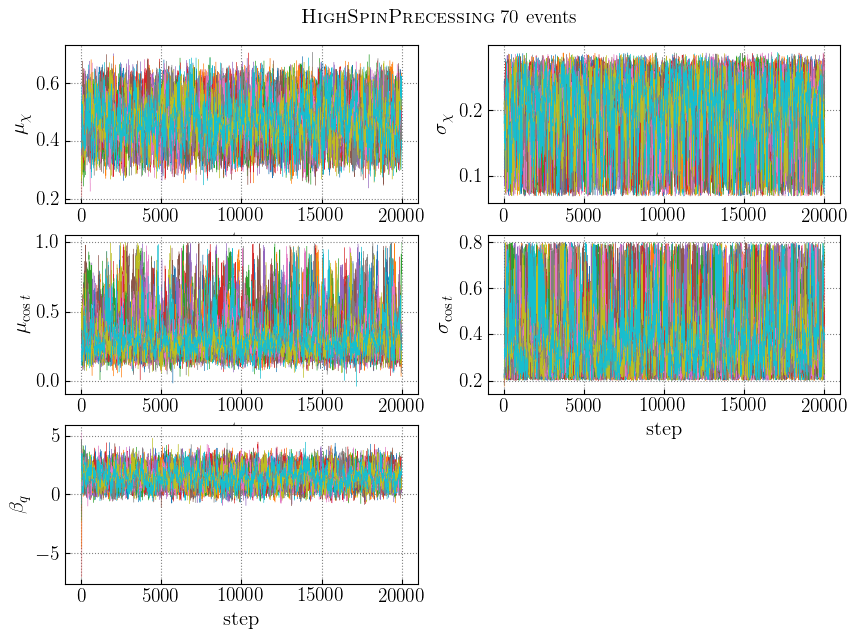

In [4]:
# Select which pop and no. events you want to look at
pop_key = 'pop 1'
nevent_key = '70 events'
data = data_dict[pop_key][nevent_key]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,7))

# mean of chi
for chain in data['mu_chi']['unprocessed']:
    axes[0][0].plot(chain, lw=0.25)
axes[0][0].set_ylabel(r'$\mu_\chi$', fontsize=15)

# sigma of chi
for chain in data['sigma_chi']['unprocessed']:
    axes[0][1].plot(chain, lw=0.25)
axes[0][1].set_ylabel(r'$\sigma_\chi$', fontsize=15)

# mean of cos(theta) 
for chain in data['mu_cost']['unprocessed']:
    axes[1][0].plot(chain, lw=0.25)
axes[1][0].set_ylabel(r'$\mu_{\cos t}$', fontsize=15)

# sigma of cos(theta)
for chain in data['sigma_cost']['unprocessed']:
    axes[1][1].plot(chain, lw=0.25)
axes[1][1].set_ylabel(r'$\sigma_{\cos t}$', fontsize=15)

# beta_q
for chain in data['Bq']['unprocessed']:
    axes[2][0].plot(chain, lw=0.25)
axes[2][0].set_ylabel(r'$\beta_{q}$', fontsize=15)

for ax in axes: 
    for a in ax:
        a.set_xlabel('step', fontsize=15)       
                
axes[2][1].set_visible(False)

plt.suptitle(population_labels_dict[pop_key] + ' ' + nevent_key, y=0.93, fontsize=14)

plt.show()

Let's make a corner plot showing posteriors on our each set of parameters:

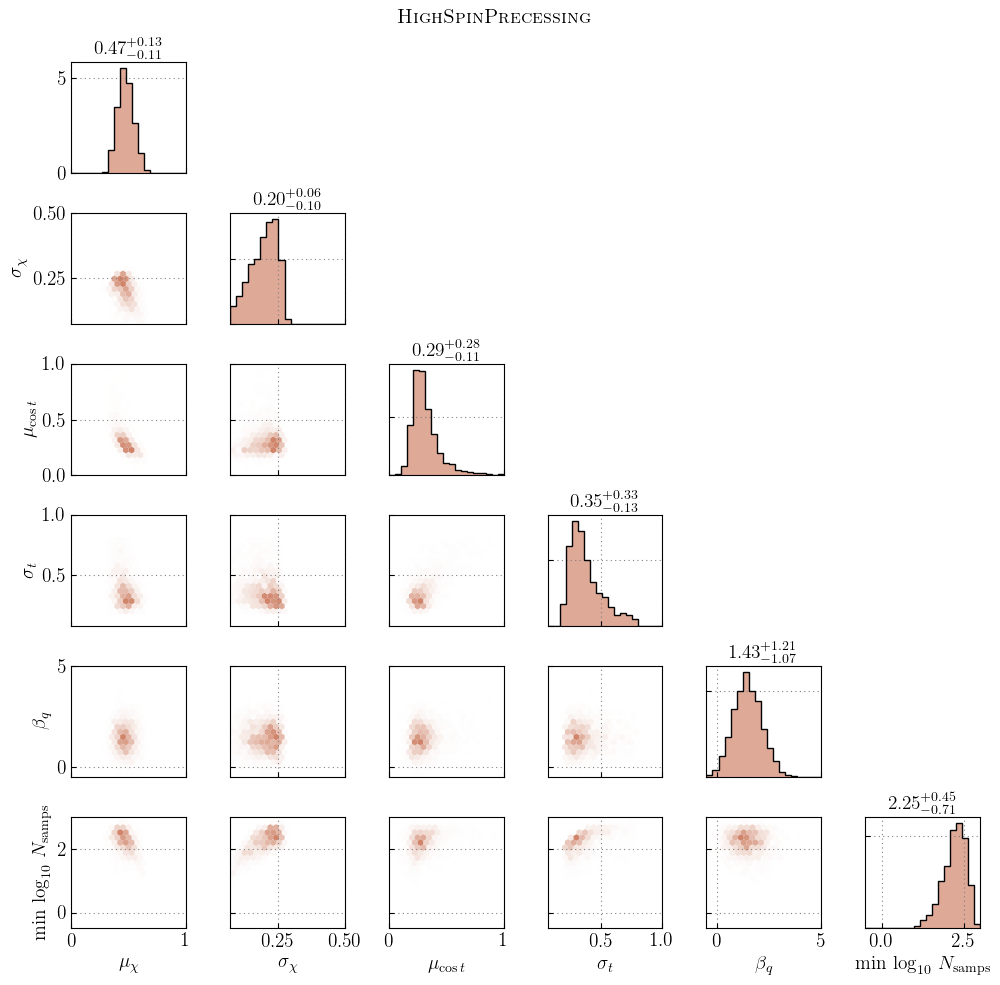

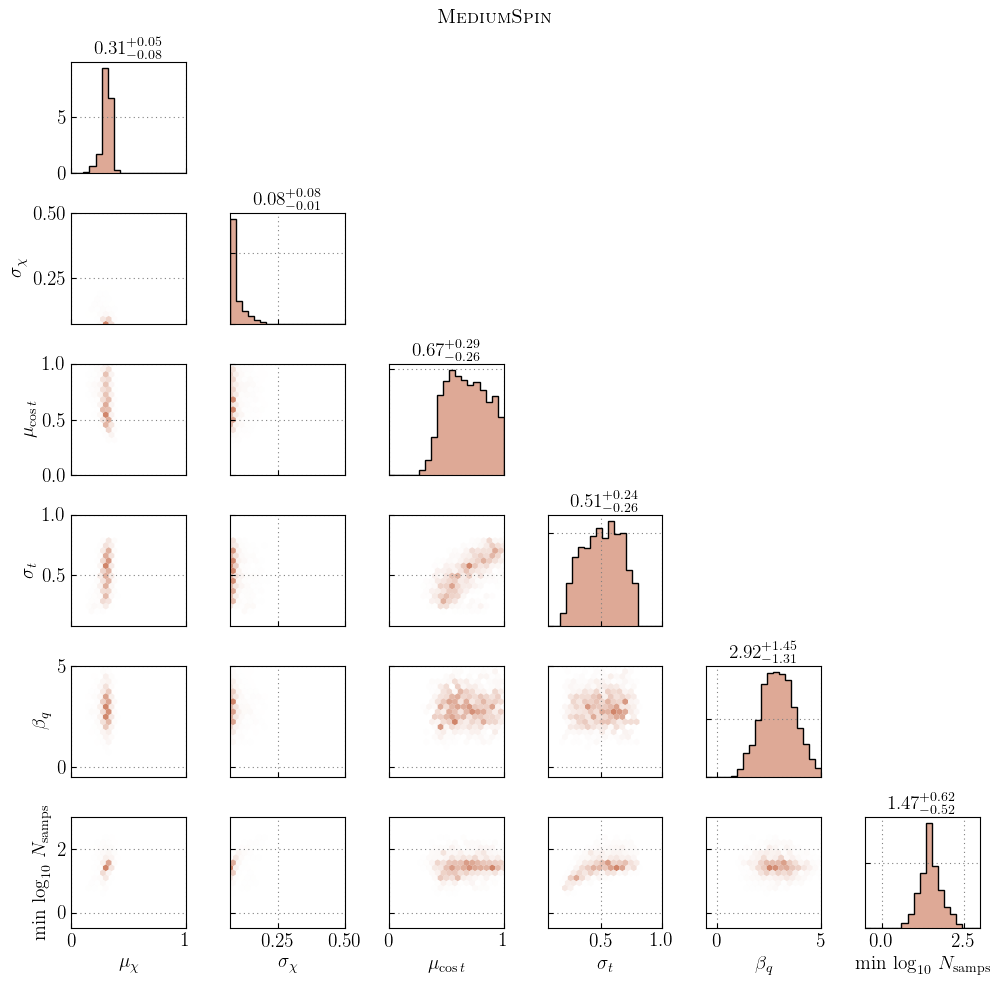

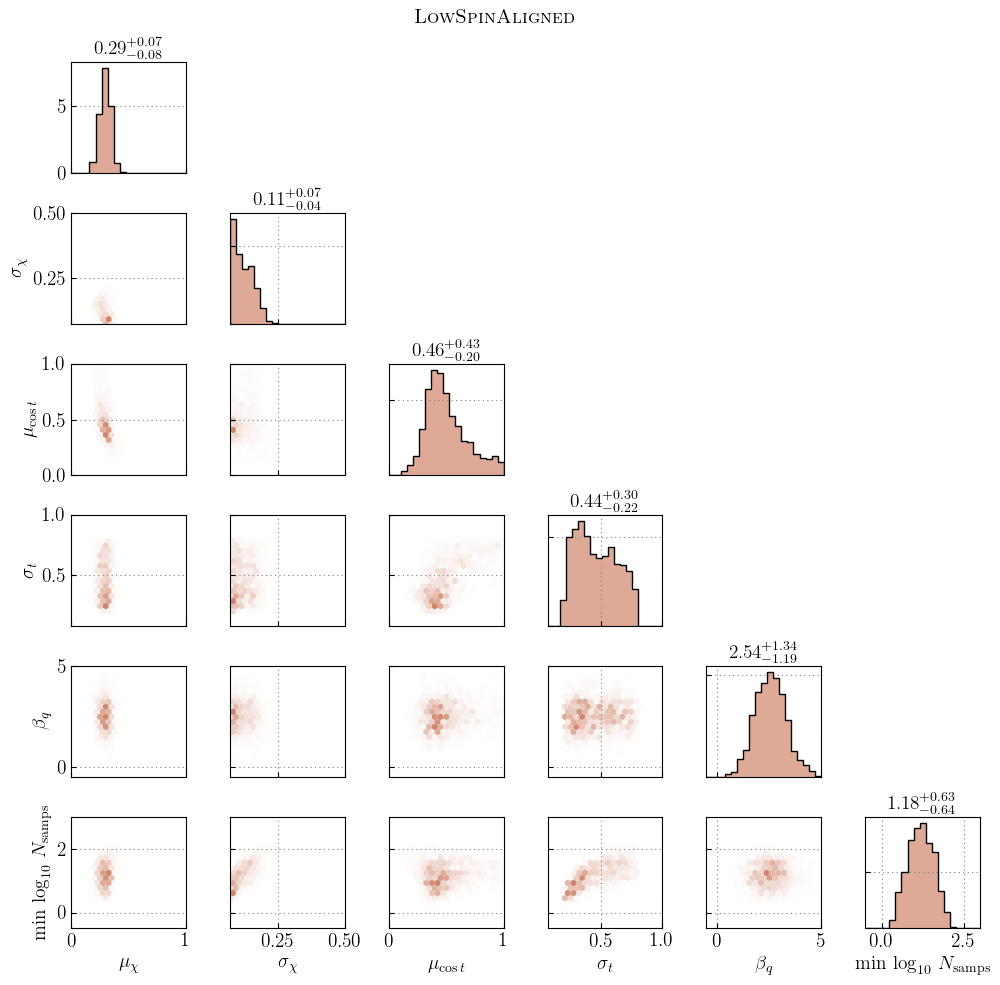

In [5]:
import importlib
importlib.reload(makeCorner)

for pop in pops: 
    
    # Fetch data
    pop_key = 'pop '+pop
    event_key = nevent+' events'
    data = data_dict[pop_key]

    # Plot
    fig = plt.figure(figsize=(10,10))

    toPlot = {
        "mu_chi":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['mu_chi']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0,1), "label":r"$\mu_\chi$"
        },
        "sigma_chi":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['sigma_chi']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0.07,0.5), "label":r"$\sigma_\chi$" 
        },
        "mu_cost":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['mu_cost']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0,1), "label":r"$\mu_{\cos t}$" 
        },
        "sigma_cost":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['sigma_cost']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(0.07,1), "label":r"$\sigma_t$" 
        }, 
        "Bq":{
            "data":{f'{nevent} events':{'posterior':data[f'{nevent} events']['Bq']['processed'], 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(-0.5,5), "label":r"$\beta_q$" 
        },
        "minNeff":{
            "data":{f'{nevent} events':{'posterior':np.log10(data[f'{nevent} events']['minNsamps']), 'color':nevents_colors_dict[f'{nevent} events']} for nevent in nevents},
            "plot_bounds":(-0.5,3), "label":r"min $\log_{10}\,N_\mathrm{samps}$" 
        }
    }

    makeCorner.plot_corner(fig,toPlot)
    plt.suptitle(population_labels_dict[pop_key], fontsize=14)
    plt.tight_layout()
    plt.show()

Finally, let's make a "trace plot" showing the set of $\chi$ and $\cos \theta$ distributions corresponding to the above samples:

In [6]:
sys.path.append('./../../Code/PopulationInference')
from posterior_helper_functions import mu_sigma2_to_a_b, calculate_betaDistribution, calculate_Gaussian_1D, calculate_Double_Gaussian

In [7]:
# True mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, f, Bq:
hyperparams = { 
    '1':[0.55, 0.26, 0.19, 0.18, 0.42, 0.75, 0.55, 0.96],  
    '2':[0.32, 0.16, 0.33, 0.64, 0.59, 0.40, 0.36, 0.96],
    '3':[0.19, 0.12, -0.98, 0.44, 0.98, 0.31, 0.26, 0.96]
}

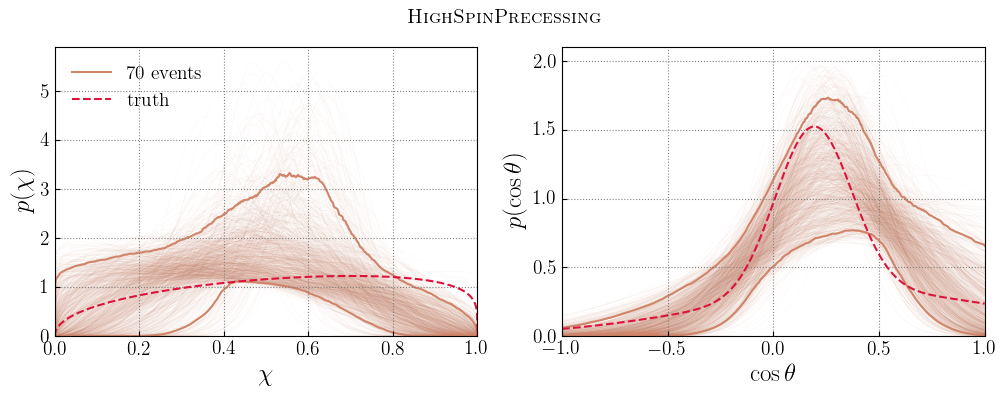

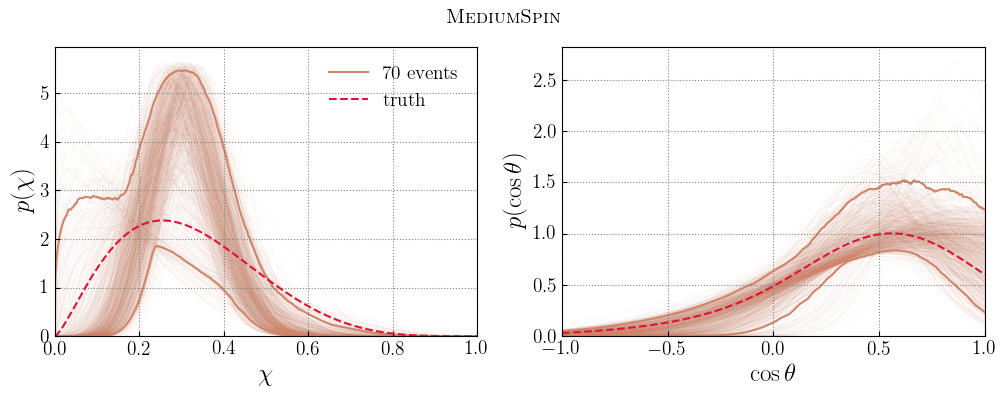

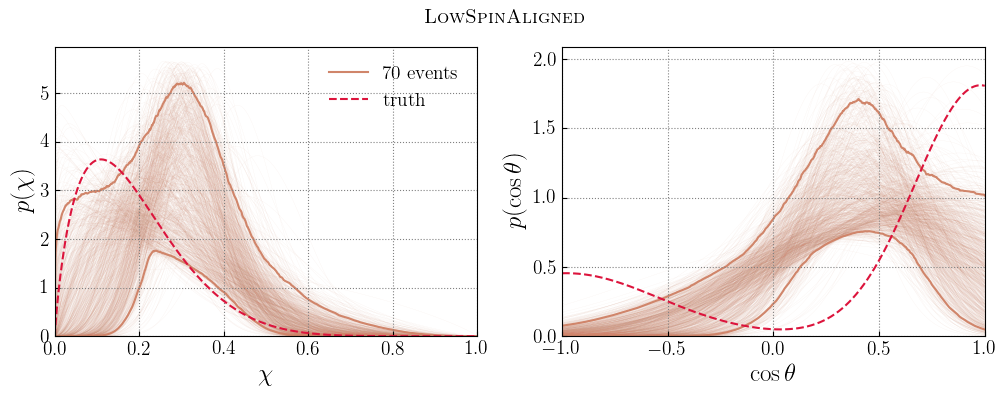

In [8]:
# Define a grid of effective spins
chi_grid = np.linspace(0,1,1000)
cost_grid = np.linspace(-1,1,1000)

# Choose a number of traces to draw
nTraces = 1000

for pop in pops: 
    
    # Set up fig and axes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3.75))
    
    for nevent in nevents: 
            
        # Fetch data
        pop_key = 'pop '+pop
        nevent_key = nevent+' events'
        data = data_dict[pop_key][nevent_key]
        
        # Instantiate an array to hold a collection of traces
        p_chi = np.zeros((nTraces,chi_grid.size))
        p_cost = np.zeros((nTraces,cost_grid.size))

        # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
        if len(data['mu_chi']['processed'])>nTraces:
            random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
        else: 
            random_indices = np.arange(len(data['mu_chi']['processed']))
        for i,ind in enumerate(random_indices):

            mu_chi = data['mu_chi']['processed'][ind]
            sigma_chi = data['sigma_chi']['processed'][ind]
            mu_cost = data['mu_cost']['processed'][ind]
            sigma_cost = data['sigma_cost']['processed'][ind]

            # calculate beta distribution for chi
            a,b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
            p_chi[i,:] = calculate_betaDistribution(chi_grid, a, b)

            # and gaussian distribution for cos(theta)
            p_cost[i,:] = calculate_Gaussian_1D(cost_grid, mu_cost, sigma_cost, -1, 1)       

        # Plot individual traces
        axes[0].plot(chi_grid, p_chi.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=0)
        axes[1].plot(cost_grid, p_cost.T,color=nevents_colors_dict[nevent_key], lw=0.15, alpha=0.15, zorder=0)

        # Also plot 5% and 95% credible bounds
        axes[0].plot(chi_grid, np.quantile(p_chi,0.05,axis=0), color=nevents_colors_dict[nevent_key], zorder=1, label=nevent_key)
        axes[0].plot(chi_grid, np.quantile(p_chi,0.95,axis=0), color=nevents_colors_dict[nevent_key], zorder=1)
        axes[1].plot(cost_grid, np.quantile(p_cost,0.05,axis=0), color=nevents_colors_dict[nevent_key], zorder=1)
        axes[1].plot(cost_grid, np.quantile(p_cost,0.95,axis=0), color=nevents_colors_dict[nevent_key], zorder=1)

    
    # Plot true distributions distributions 
    mu_chi_true = hyperparams[pop][0]
    sigma_chi_true = hyperparams[pop][1]
    a_true, b_true = mu_sigma2_to_a_b(mu_chi_true, sigma_chi_true**2)
    p_chi_true = calculate_betaDistribution(chi_grid, a_true, b_true)
    mu1_cost_true = hyperparams[pop][2]
    sigma1_cost_true = hyperparams[pop][3]
    mu2_cost_true = hyperparams[pop][4]
    sigma2_cost_true = hyperparams[pop][5]
    MF_cost_true = hyperparams[pop][6]
    p_cost_true = calculate_Double_Gaussian(cost_grid, mu1_cost_true, sigma1_cost_true, mu2_cost_true, sigma2_cost_true, MF_cost_true, -1, 1)
    axes[0].plot(chi_grid, p_chi_true, color='crimson', ls='--', zorder=2, label='truth')
    axes[1].plot(cost_grid, p_cost_true ,color='crimson', ls='--', zorder=2)
    
    
    axes[0].set_xlim(0,1)
    axes[0].set_ylim(0,)
    axes[0].set_xlabel(r'$\chi$',fontsize=18)
    axes[0].set_ylabel(r'$p(\chi)$',fontsize=18)
    axes[0].legend()

    axes[1].set_xlim(-1,1)
    axes[1].set_ylim(0,)
    axes[1].set_xlabel(r'$\cos \theta$',fontsize=18)
    axes[1].set_ylabel(r'$p(\cos \theta)$',fontsize=18)

    plt.suptitle(population_labels_dict[pop_key], fontsize=14)

    plt.show()